## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap
import time
import os
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

d:\Program Files\conda_envs\nitor_kuas\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configs

In [2]:
train_path = '../data/train.csv'
test_path = '../data/test_for_participants.csv'
sample_path = '../data/sample_submission.csv'

# ── Dual Validation Date Boundaries ──────────────────────────────
# Val Set 1 (Physics): Autumn/Winter 2024 — cold, dark, windy grid
VAL_PHYSICS_START = '2024-09-01'
VAL_PHYSICS_END   = '2025-01-01'
# Val Set 2 (Recency): Summer 2025 — last 3 months before LB
VAL_RECENCY_START = '2025-06-01'

SEED = 42

os.makedirs('../models', exist_ok=True)

# Set random seed for reproducibility
np.random.seed(SEED)

## Data Loading

In [3]:
train_raw = pd.read_csv(train_path)
test_raw = pd.read_csv(test_path)
sample_sub = pd.read_csv(sample_path)

In [4]:
for df in [train_raw, test_raw]:
    df['delivery_start'] = pd.to_datetime(df['delivery_start'])
    df['delivery_end'] = pd.to_datetime(df['delivery_end'])

train_raw['is_test'] = 0
test_raw['is_test'] = 1
test_raw['target'] = np.nan

df = pd.concat([train_raw, test_raw], ignore_index=True)
df = df.sort_values(['market', 'delivery_start']).reset_index(drop=True)
df.head()

,id,target,market,global_horizontal_irradiance,diffuse_horizontal_irradiance,direct_normal_irradiance,cloud_cover_total,cloud_cover_low,cloud_cover_mid,cloud_cover_high,...,wind_speed_80m,wind_direction_80m,wind_gust_speed_10m,wind_speed_10m,solar_forecast,wind_forecast,load_forecast,delivery_start,delivery_end,is_test
0,0,-1.913,Market A,0.0,0.0,0.0,2.0,0.0,0.0,2.0,...,31.253719,245.501450,25.199999,15.077082,0.0,24050.1,38163.0100,2023-01-01 00:00:00,2023-01-01 01:00:00,0
1,5,-0.839,Market A,0.0,0.0,0.0,15.0,0.0,0.0,15.0,...,30.918108,242.241547,23.400000,14.186923,0.0,23886.3,37379.1898,2023-01-01 01:00:00,2023-01-01 02:00:00,0
2,10,-1.107,Market A,0.0,0.0,0.0,17.0,0.0,0.0,17.0,...,26.983196,224.999893,21.240000,12.413477,0.0,23366.5,36336.8303,2023-01-01 02:00:00,2023-01-01 03:00:00,0
3,15,0.035,Market A,0.0,0.0,0.0,16.0,0.0,0.0,16.0,...,22.218153,229.600174,16.199999,10.483357,0.0,22829.8,35337.7595,2023-01-01 03:00:00,2023-01-01 04:00:00,0
4,20,-0.829,Market A,0.0,0.0,0.0,10.0,0.0,0.0,10.0,...,27.210381,244.113022,18.359999,11.918120,0.0,22347.6,34474.3403,2023-01-01 04:00:00,2023-01-01 05:00:00,0


## EDA & Target Plotting

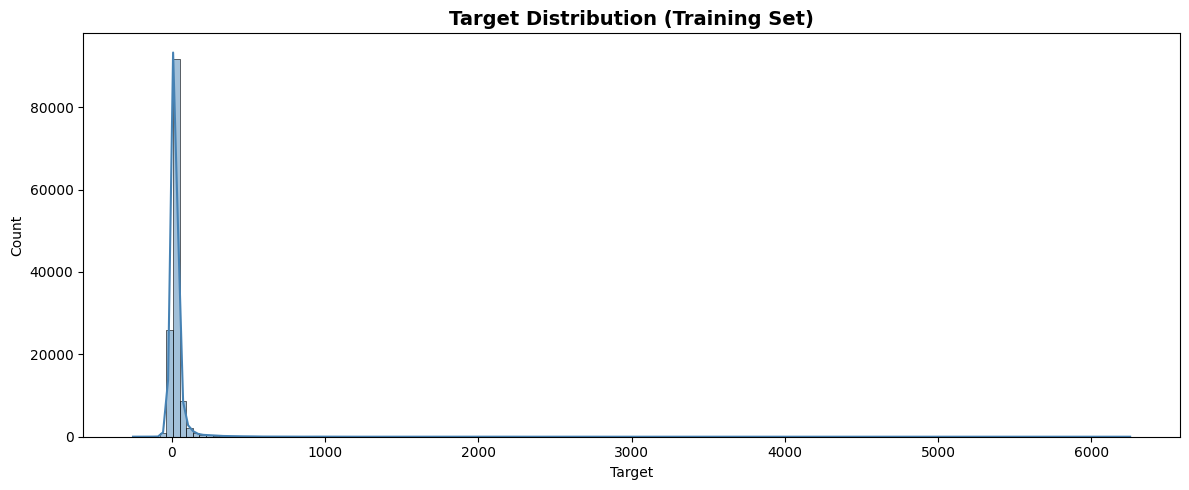

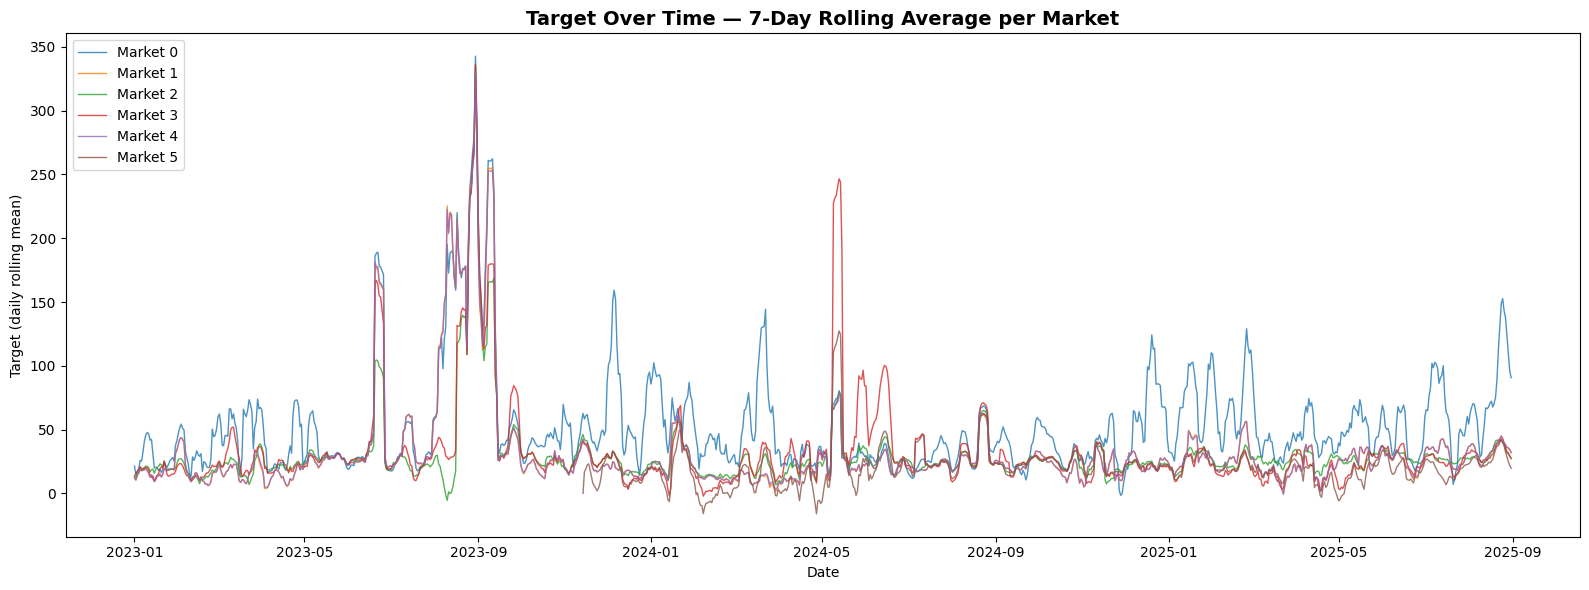

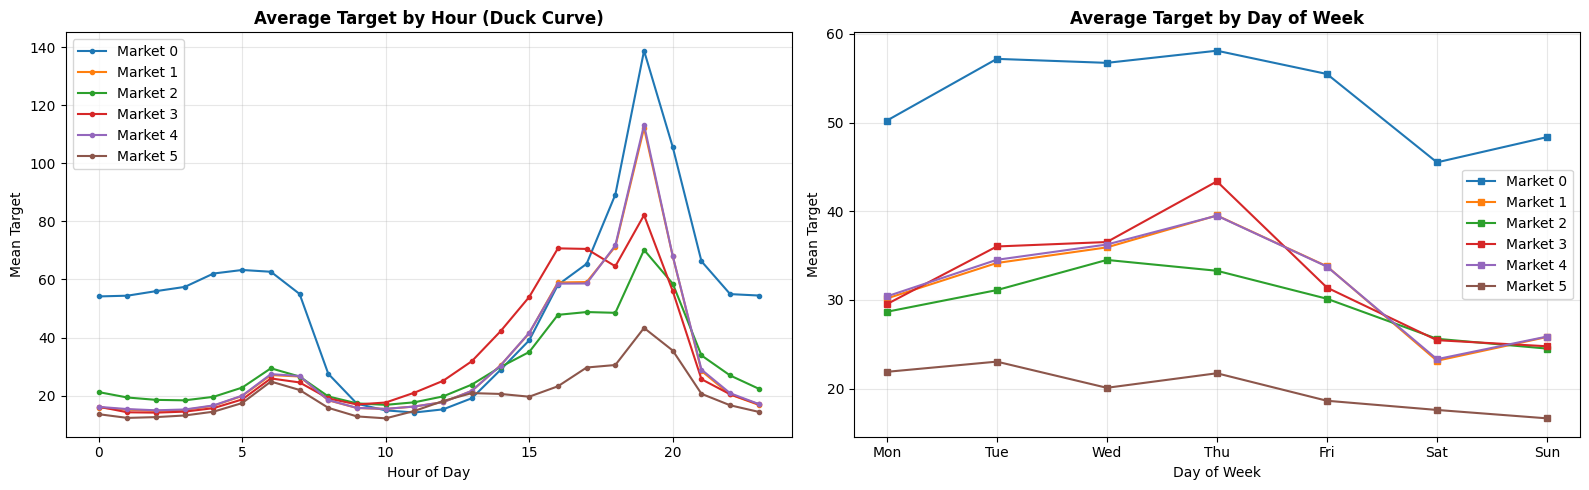

✅ EDA complete


In [5]:
# ══════════════════════════════════════════════════════════════════════════════
# EDA & TARGET PLOTTING (self-contained — uses df before feature engineering)
# ══════════════════════════════════════════════════════════════════════════════

_observed = df[df['is_test'] == 0].copy()

# --- Extract basic time columns for EDA ---
_observed['hour']        = _observed['delivery_start'].dt.hour
_observed['day_of_week'] = _observed['delivery_start'].dt.dayofweek
_observed['date']        = _observed['delivery_start'].dt.date

# Market mapping
_market_map = {f"Market {c}": i for i, c in enumerate("ABCDEF")}
_observed['market_id'] = _observed['market'].map(_market_map)

# ── Plot A: Target Distribution ──────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(_observed['target'], bins=150, kde=True, ax=ax, color='steelblue')
ax.set_title('Target Distribution (Training Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Target')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# ── Plot B: Macro Time-Series (daily rolling avg per market) ─────────────────
fig, ax = plt.subplots(figsize=(16, 6))
for mkt in sorted(_observed['market_id'].unique()):
    mdf = _observed[_observed['market_id'] == mkt].copy()
    daily = mdf.groupby('date')['target'].mean().rolling(7, min_periods=1).mean()
    ax.plot(daily.index, daily.values, label=f'Market {mkt}', alpha=0.8, linewidth=1)
ax.set_title('Target Over Time — 7-Day Rolling Average per Market', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Target (daily rolling mean)')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

# ── Plot C: Duck Curves ──────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# C-1: Avg target by hour (per market)
for mkt in sorted(_observed['market_id'].unique()):
    mdf = _observed[_observed['market_id'] == mkt]
    hourly = mdf.groupby('hour')['target'].mean()
    axes[0].plot(hourly.index, hourly.values, label=f'Market {mkt}', marker='o', markersize=3)
axes[0].set_title('Average Target by Hour (Duck Curve)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Mean Target')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# C-2: Avg target by day of week (per market)
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for mkt in sorted(_observed['market_id'].unique()):
    mdf = _observed[_observed['market_id'] == mkt]
    dow = mdf.groupby('day_of_week')['target'].mean()
    axes[1].plot(dow.index, dow.values, label=f'Market {mkt}', marker='s', markersize=4)
axes[1].set_title('Average Target by Day of Week', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Mean Target')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(dow_labels)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

del _observed   # clean up EDA-only dataframe
print("✅ EDA complete")

## Enhanced Feature Engineering - Ultra Advanced Version

In [6]:
# Basic time features
ds = df["delivery_start"]
df["hour"]         = ds.dt.hour
df["day_of_week"]  = ds.dt.dayofweek
df["day_of_month"] = ds.dt.day
df["month"]        = ds.dt.month
df["quarter"]      = ds.dt.quarter
df["day_of_year"]  = ds.dt.dayofyear
df["year"]         = ds.dt.year
df["is_weekend"]   = (ds.dt.dayofweek >= 5).astype(np.int8)
df["week_of_year"] = ds.dt.isocalendar().week.astype(int)

# Cyclical encoding for time features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Market encoding
market_map = {f"Market {c}": i for i, c in enumerate("ABCDEF")}
df["market_id"] = df["market"].map(market_map).astype(np.int8)

# Advanced demand and supply features
df["residual_demand"] = df["load_forecast"] - df["solar_forecast"] - df["wind_forecast"]
df["supply_ratio"] = (df["solar_forecast"] + df["wind_forecast"]) / (df["load_forecast"] + 1)
df["renewable_ratio"] = (df["solar_forecast"] + df["wind_forecast"]) / (df["solar_forecast"] + df["wind_forecast"] + df["load_forecast"] + 1)
df["net_supply"] = df["solar_forecast"] + df["wind_forecast"]
df["demand_supply_balance"] = df["load_forecast"] / (df["solar_forecast"] + df["wind_forecast"] + 1)

# Tightness ratios
df["tightness_ratio"] = df["residual_demand"] / (df["load_forecast"] + 1)
df["tightness_x_month"] = df["tightness_ratio"] * df["month"]
df["tightness_x_hour"] = df["tightness_ratio"] * df["hour"]
df["tightness_x_dow"] = df["tightness_ratio"] * df["day_of_week"]

# Price sensitivity indicators
df["solar_wind_ratio"] = df["solar_forecast"] / (df["wind_forecast"] + 1)
df["wind_solar_ratio"] = df["wind_forecast"] / (df["solar_forecast"] + 1)

In [7]:
# ── Advanced Weather Physics Features ──────────────────────────────────────
# First, alias columns whose names differ between dataset and our code

if 'convective_available_potential_energy' in df.columns:
    df['cape'] = df['convective_available_potential_energy']
if 'precipitation_amount' in df.columns:
    df['precipitation'] = df['precipitation_amount']
if 'apparent_temperature_2m' in df.columns:
    df['apparent_temperature'] = df['apparent_temperature_2m']
if 'freezing_level_height' in df.columns:
    df['boundary_layer_height'] = df['freezing_level_height']

# Estimate missing columns from available physics
# Saturation vapour pressure (Tetens formula)
es = 6.112 * np.exp((17.67 * df['air_temperature_2m']) / (df['air_temperature_2m'] + 243.5))
ea = (df['relative_humidity_2m'] / 100.0) * es
df['vapour_pressure_deficit_2m'] = es - ea

# Proxy precipitation probability from relative humidity
df['precipitation_probability'] = np.where(df['relative_humidity_2m'] > 85, 50, 0)

# ── Derived weather features ──
df['dew_point_depression']  = df['air_temperature_2m'] - df['dew_point_temperature_2m']
df['wet_bulb_depression']   = df['air_temperature_2m'] - df['wet_bulb_temperature_2m']
df['humidity_ratio']        = (0.622 * df['vapour_pressure_deficit_2m']) / (df['surface_pressure'] - df['vapour_pressure_deficit_2m'])
df['blh_normalized_pressure'] = df['boundary_layer_height'] / (df['surface_pressure'] / 1000)

# Wind shear (10m vs 80m)
df['wind_shear']       = df['wind_speed_80m'] - df['wind_speed_10m']
df['wind_shear_ratio'] = df['wind_speed_80m'] / (df['wind_speed_10m'] + 0.1)

# Convection indices
df['cape_cin_interaction'] = df['cape'] * df['convective_inhibition']
df['convection_potential'] = df['cape'] / (abs(df['convective_inhibition']) + 1)

# Visibility & cloud
df['visibility_cloud_interaction'] = df['visibility'] / (df['cloud_cover_total'] + 1)

# Combined weather severity index
df['weather_severity'] = (
    df['cloud_cover_total'] / 100 +
    (100 - df['visibility'].clip(0, 100)) / 100 +
    df['precipitation_probability'] / 100 +
    df['cape'] / 1000
) / 4

# Solar / wind potential
df['solar_potential'] = df['global_horizontal_irradiance'] * (1 - df['cloud_cover_total'] / 100)
df['wind_potential']  = df['wind_speed_80m'] ** 3  # cubic ∝ power

# Extreme weather flags
df['extreme_temp']   = ((df['air_temperature_2m'] > 30) | (df['air_temperature_2m'] < -5)).astype(int)
df['extreme_wind']   = (df['wind_speed_80m'] > 25).astype(int)
df['extreme_precip'] = (df['precipitation'] > 5).astype(int)

# Seasonal × weather interactions
df['temp_month_interaction'] = df['air_temperature_2m'] * df['month']
df['wind_month_interaction'] = df['wind_speed_80m'] * df['month']
df['solar_hour_interaction'] = df['solar_forecast'] * df['hour']

# Heating / cooling degree-hours
df['cooling_degree_hours'] = np.maximum(df['air_temperature_2m'] - 22, 0)
df['heating_degree_hours'] = np.maximum(18 - df['air_temperature_2m'], 0)

# Vapour pressure deficit normalised
df['vpd_normalized'] = df['vapour_pressure_deficit_2m'] / df['surface_pressure']

# Apparent temperature anomaly
df['apparent_temp_anomaly']   = df['apparent_temperature'] - df['air_temperature_2m']
df['apparent_air_temp_ratio'] = df['apparent_temperature'] / (df['air_temperature_2m'] + 1)

# Lifted Index feature (strong storm predictor)
if 'lifted_index' in df.columns:
    df['lifted_index_negative'] = (-df['lifted_index']).clip(lower=0)  # only instability

In [8]:
# ── Weather Momentum & Lag Features (NO target leakage) ────────────────────
weather_cols = ['wind_speed_80m', 'solar_forecast', 'load_forecast',
                'wind_forecast', 'air_temperature_2m']

for col in weather_cols:
    grp = df.groupby('market_id')[col]

    # Hourly differences (momentum)
    df[f'{col}_diff_1h']  = grp.diff(1)
    df[f'{col}_diff_3h']  = grp.diff(3)
    df[f'{col}_diff_6h']  = grp.diff(6)
    df[f'{col}_diff_12h'] = grp.diff(12)

    # Rolling mean / std
    df[f'{col}_rolling_mean_6h']  = grp.transform(lambda x: x.rolling(6,  min_periods=1).mean())
    df[f'{col}_rolling_std_6h']   = grp.transform(lambda x: x.rolling(6,  min_periods=1).std().fillna(0))
    df[f'{col}_rolling_mean_24h'] = grp.transform(lambda x: x.rolling(24, min_periods=1).mean())
    df[f'{col}_rolling_std_24h']  = grp.transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))

    # Rolling min / max (use bfill() instead of deprecated fillna(method=...))
    df[f'{col}_rolling_min_24h'] = grp.transform(lambda x: x.rolling(24, min_periods=1).min().bfill())
    df[f'{col}_rolling_max_24h'] = grp.transform(lambda x: x.rolling(24, min_periods=1).max().bfill())
    df[f'{col}_range_24h']       = df[f'{col}_rolling_max_24h'] - df[f'{col}_rolling_min_24h']

    # Exponential weighted moving averages
    df[f'{col}_ewm_6h']  = grp.transform(lambda x: x.ewm(span=6,  adjust=False).mean())
    df[f'{col}_ewm_24h'] = grp.transform(lambda x: x.ewm(span=24, adjust=False).mean())

    # Z-score vs rolling window
    df[f'{col}_zscore_24h'] = (df[col] - df[f'{col}_rolling_mean_24h']) / (df[f'{col}_rolling_std_24h'] + 0.001)

# Temperature anomaly vs recent history
df['temp_24h_mean']    = df.groupby('market_id')['air_temperature_2m'].transform(lambda x: x.rolling(24, min_periods=1).mean())
df['temp_72h_mean']    = df.groupby('market_id')['air_temperature_2m'].transform(lambda x: x.rolling(72, min_periods=1).mean())
df['temp_anomaly_24h'] = df['air_temperature_2m'] - df['temp_24h_mean']
df['temp_anomaly_72h'] = df['air_temperature_2m'] - df['temp_72h_mean']

# Wind direction components & stability
df['wind_dir_sin']    = np.sin(np.deg2rad(df['wind_direction_80m']))
df['wind_dir_cos']    = np.cos(np.deg2rad(df['wind_direction_80m']))
df['wind_dir_change'] = df.groupby('market_id')['wind_direction_80m'].diff(1).abs()

# Pressure & humidity interactions with temperature
df['pressure_temp_interaction']  = df['surface_pressure'] * df['air_temperature_2m']
df['humidity_temp_interaction']  = df['relative_humidity_2m'] * df['air_temperature_2m']
df['pressure_gradient']          = df.groupby('market_id')['surface_pressure'].diff(1)

# Cloud & precipitation transforms
df['cloud_cover_total_sq']  = df['cloud_cover_total'] ** 2
df['cloud_cover_effect']    = df['cloud_cover_total'] * df['global_horizontal_irradiance']
df['precip_prob_sq']        = df['precipitation_probability'] ** 2
df['precip_effect']         = df['precipitation'] * df['precipitation_probability']

# Radiation efficiency
df['solar_efficiency']       = df['solar_forecast'] / (df['global_horizontal_irradiance'] + 1)
df['radiation_cloud_ratio']  = df['global_horizontal_irradiance'] / (df['cloud_cover_total'] + 1)

In [9]:
# Advanced temporal features

# Hourly and daily patterns
df['hour_from_peak'] = abs(df['hour'] - 12)  # Distance from peak solar hour
df['is_peak_solar'] = ((df['hour'] >= 10) & (df['hour'] <= 16)).astype(int)
df['is_off_peak'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
df['is_business_hours'] = ((df['hour'] >= 8) & (df['hour'] <= 18) & (df['day_of_week'] < 5)).astype(int)

# Week patterns
df['is_monday'] = (df['day_of_week'] == 0).astype(int)
df['is_friday'] = (df['day_of_week'] == 4).astype(int)
df['is_weekend_start'] = (df['day_of_week'] == 4).astype(int)  # Friday
df['is_weekend_end'] = (df['day_of_week'] == 6).astype(int)    # Sunday

# Monthly patterns
df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
df['is_autumn'] = df['month'].isin([9, 10, 11]).astype(int)

# Quarter interactions
df['q1_temp_interaction'] = (df['quarter'] == 1) * df['air_temperature_2m']
df['q2_temp_interaction'] = (df['quarter'] == 2) * df['air_temperature_2m']
df['q3_temp_interaction'] = (df['quarter'] == 3) * df['air_temperature_2m']
df['q4_temp_interaction'] = (df['quarter'] == 4) * df['air_temperature_2m']

# Seasonal demand patterns
df['winter_load_factor'] = df['is_winter'] * df['load_forecast']
df['summer_load_factor'] = df['is_summer'] * df['load_forecast']
df['spring_load_factor'] = df['is_spring'] * df['load_forecast']
df['autumn_load_factor'] = df['is_autumn'] * df['load_forecast']

In [10]:
# ══════════════════════════════════════════════════════════════════════════════
# Historical Target Encoding  (VALIDATION-SAFE MODE — v6 Dual Val)
# ══════════════════════════════════════════════════════════════════════════════
# For tuning/validation: compute group means ONLY from TRAINING data
# (excluding both validation sets) to avoid any leakage.

# ⚠️ VALIDATION MODE: using only training data (pre-Physics val start)
# For final submission, change to:
#     strict_train = df[(df['is_test'] == 0) & (df['delivery_start'] < VAL_PHYSICS_START)]
strict_train = df[(df['is_test'] == 0) & (df['delivery_start'] < VAL_PHYSICS_START)]

# ── Market × Hour mean ──
mean_mh = (strict_train
    .groupby(['market_id', 'hour'])['target']
    .mean().reset_index(name='target_histmean_mh'))

# ── Market × Day-of-week mean ──
mean_mdow = (strict_train
    .groupby(['market_id', 'day_of_week'])['target']
    .mean().reset_index(name='target_histmean_mdow'))

# ── Market × Month mean ──
mean_mm = (strict_train
    .groupby(['market_id', 'month'])['target']
    .mean().reset_index(name='target_histmean_mm'))

# ── Market mean (global baseline per market) ──
mean_m = (strict_train
    .groupby(['market_id'])['target']
    .mean().reset_index(name='target_histmean_m'))

# ── Hour mean (global baseline per hour) ──
mean_h = (strict_train
    .groupby(['hour'])['target']
    .mean().reset_index(name='target_histmean_h'))

# ── Market × Hour × DayOfWeek mean ──
mean_mhd = (strict_train
    .groupby(['market_id', 'hour', 'day_of_week'])['target']
    .mean().reset_index(name='target_histmean_mhd'))

# ── Market × Quarter mean ──
mean_mq = (strict_train
    .groupby(['market_id', 'quarter'])['target']
    .mean().reset_index(name='target_histmean_mq'))

# Merge ALL onto full dataframe
df = df.merge(mean_mh,  on=['market_id', 'hour'],          how='left')
df = df.merge(mean_mdow, on=['market_id', 'day_of_week'],  how='left')
df = df.merge(mean_mm,  on=['market_id', 'month'],          how='left')
df = df.merge(mean_m,   on=['market_id'],                   how='left')
df = df.merge(mean_h,   on=['hour'],                        how='left')
df = df.merge(mean_mhd, on=['market_id', 'hour', 'day_of_week'], how='left')
df = df.merge(mean_mq,  on=['market_id', 'quarter'],       how='left')

# Fill any NaN hist-means with global training mean
global_mean = strict_train['target'].mean()
for c in [c for c in df.columns if c.startswith('target_histmean_')]:
    df[c] = df[c].fillna(global_mean)

# ── Deviations from historical baselines (computed from safe features only) ──
df['histmean_mh_x_residual'] = df['target_histmean_mh'] * df['residual_demand']
df['histmean_mh_x_tightness'] = df['target_histmean_mh'] * df['tightness_ratio']
df['histmean_deviation_dow_vs_m'] = df['target_histmean_mdow'] - df['target_histmean_m']
df['histmean_deviation_mh_vs_h'] = df['target_histmean_mh'] - df['target_histmean_h']

print(f"✅ Safe historical encoding: {sum(c.startswith('target_histmean') for c in df.columns)} features")
print(f"   Global training mean: {global_mean:.4f}")

✅ Safe historical encoding: 7 features
   Global training mean: 37.3241


In [11]:
# ── Interaction features (weather × demand, cross-market) ──────────────────
df['temp_load_interaction']  = df['air_temperature_2m'] * df['load_forecast']
df['wind_load_interaction']  = df['wind_speed_80m'] * df['load_forecast']
df['solar_load_interaction'] = df['solar_forecast'] * df['load_forecast']
df['temp_wind_interaction']  = df['air_temperature_2m'] * df['wind_speed_80m']
df['temp_solar_interaction'] = df['air_temperature_2m'] * df['solar_forecast']
df['wind_solar_interaction'] = df['wind_speed_80m'] * df['solar_forecast']

# Triple interactions
df['temp_wind_load_interaction']  = df['air_temperature_2m'] * df['wind_speed_80m'] * df['load_forecast']
df['temp_solar_load_interaction'] = df['air_temperature_2m'] * df['solar_forecast'] * df['load_forecast']
df['wind_solar_load_interaction'] = df['wind_speed_80m'] * df['solar_forecast'] * df['load_forecast']

# Weather volatility (rolling on weather — safe, no target)
df['temp_volatility']  = df.groupby('market_id')['air_temperature_2m'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))
df['wind_volatility']  = df.groupby('market_id')['wind_speed_80m'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))
df['solar_volatility'] = df.groupby('market_id')['solar_forecast'].transform(lambda x: x.rolling(24, min_periods=1).std().fillna(0))

# Rate of change (weather — safe)
df['temp_rate_change']  = df.groupby('market_id')['air_temperature_2m'].diff(1) / (df.groupby('market_id')['air_temperature_2m'].shift(1).abs() + 0.01)
df['wind_rate_change']  = df.groupby('market_id')['wind_speed_80m'].diff(1) / (df.groupby('market_id')['wind_speed_80m'].shift(1).abs() + 0.01)
df['solar_rate_change'] = df.groupby('market_id')['solar_forecast'].diff(1) / (df.groupby('market_id')['solar_forecast'].shift(1).abs() + 0.01)

# Cross-market features (same timestamp, across markets — safe)
for col in ['wind_speed_80m', 'solar_forecast', 'load_forecast']:
    ts_mean = df.groupby('delivery_start')[col].transform('mean')
    ts_std  = df.groupby('delivery_start')[col].transform('std') + 0.001
    df[f'{col}_market_diff']   = df[col] - ts_mean
    df[f'{col}_market_zscore'] = (df[col] - ts_mean) / ts_std

# Advanced rolling statistics (weather — safe)
for col in ['wind_speed_80m', 'solar_forecast', 'load_forecast']:
    df[f'{col}_skew_24h'] = df.groupby('market_id')[col].transform(
        lambda x: x.rolling(24, min_periods=12).skew().fillna(0))


# ── SUMMER HEATWAVE & GRID STRESS ──────────────────────────────────────────────
# 1. Heatwave Penalty (Exponential stress when Temp > 25C and Wind is low)
df['heatwave_stress'] = np.where(
    (df['air_temperature_2m'] > 25) & (df['wind_speed_80m'] < 5),
    (df['air_temperature_2m'] - 25) ** 2, 
    0
)

# 2. Solar/Wind Drought Flag
df['renewable_drought'] = ((df['solar_forecast'] < 10) & (df['wind_forecast'] < 10)).astype(int)

# 3. Summer Cooling Load Proxy
df['cooling_degree_load'] = df['load_forecast'] * np.maximum(0, df['air_temperature_2m'] - 22)


# ── WINTER PHYSICS & GRID STRESS ──────────────────────────────────────────
# 1. Heating Degree Load (Demand spikes exponentially as temp drops below 18C)
df['heating_degree_load'] = df['load_forecast'] * np.maximum(0, 18 - df['air_temperature_2m'])

# 2. Wind Turbine Cut-Out Risk (Turbines shut down in extreme storms > 22 m/s)
# When wind is extremely high, supply crashes unexpectedly.
df['wind_cutout_risk'] = (df['wind_speed_80m'] > 22).astype(int)
df['wind_cutout_penalty'] = df['wind_cutout_risk'] * df['residual_demand']

# 3. "Dunkelflaute" (Dark Calm) Freezing Penalty
# High demand (Temp < 5C) + Zero Solar + Low Wind (< 5 m/s)
df['dark_cold_stress'] = np.where(
    (df['air_temperature_2m'] < 5) & (df['solar_forecast'] < 10) & (df['wind_speed_80m'] < 5),
    (5 - df['air_temperature_2m']) * df['load_forecast'], 
    0
)

# 4. Wind Chill Proxy (Accelerates heating demand)
df['wind_chill_proxy'] = np.where(
    df['air_temperature_2m'] < 10,
    df['air_temperature_2m'] - (df['wind_speed_80m'] * 0.5),
    df['air_temperature_2m']
)

# ── Final NaN handling ─────────────────────────────────────────────────────
# NEVER fill target NaN — those are test rows!
exclude_from_fill = {'target', 'delivery_start', 'delivery_end', 'market', 'id'}
for col in df.columns:
    if col in exclude_from_fill:
        continue
    if df[col].dtype in ['float64', 'float32', 'int64', 'int32', 'int8']:
        nan_count = df[col].isna().sum()
        if nan_count > 0:
            df[col] = df[col].fillna(df[col].median())

print(f"✅ Feature engineering complete: {len(df.columns)} total columns")
print(f"   Training rows: {(df['is_test']==0).sum()}, Test rows: {(df['is_test']==1).sum()}")
print(f"   NaN check (target): {df['target'].isna().sum()} NaN (should equal test rows)")

✅ Feature engineering complete: 240 total columns
   Training rows: 132608, Test rows: 13098
   NaN check (target): 13098 NaN (should equal test rows)


## Feature Pruning

In [12]:
print('--- PRUNING USELESS FEATURES ---')
useless_features = [
    'precip_prob_sq', 'precipitation', 'load_forecast_market_zscore', 
    'load_forecast_market_diff', 'extreme_temp', 'extreme_precip', 
    'is_off_peak', 'heatwave_stress', 'dark_cold_stress', 'precip_effect', 
    'quarter', 'solar_forecast_rolling_min_24h', 'renewable_drought', 
    'precipitation_amount', 'precipitation_probability', 'is_summer', 
    'is_autumn', 'is_monday', 'hour_from_peak', 'is_peak_solar'
]
actual_drops = [c for c in useless_features if c in df.columns]
df.drop(columns=actual_drops, inplace=True)
print(f'Dropped {len(actual_drops)} useless features with 0.0 Gain.')

print('\n--- PRUNING CORRELATED FEATURES ---')
# Only calculate correlation on numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
# Exclude the target from being dropped!
if 'target' in numeric_cols:
    numeric_cols = numeric_cols.drop('target')

# Calculate absolute correlation matrix
corr_matrix = df[numeric_cols].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.98
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.98)]

print(f'Found {len(to_drop_corr)} highly correlated features (>0.98):')
print(to_drop_corr)

# Drop them
df.drop(columns=to_drop_corr, inplace=True)
print(f'DataFrame shape after all pruning: {df.shape}')

--- PRUNING USELESS FEATURES ---
Dropped 20 useless features with 0.0 Gain.

--- PRUNING CORRELATED FEATURES ---
Found 33 highly correlated features (>0.98):
['day_of_year', 'week_of_year', 'renewable_ratio', 'tightness_ratio', 'cape', 'apparent_temperature', 'boundary_layer_height', 'dew_point_depression', 'humidity_ratio', 'blh_normalized_pressure', 'vpd_normalized', 'wind_speed_80m_ewm_6h', 'solar_forecast_rolling_max_24h', 'solar_forecast_range_24h', 'solar_forecast_ewm_6h', 'load_forecast_rolling_max_24h', 'load_forecast_range_24h', 'load_forecast_ewm_6h', 'wind_forecast_ewm_6h', 'air_temperature_2m_ewm_6h', 'air_temperature_2m_ewm_24h', 'temp_24h_mean', 'pressure_temp_interaction', 'cloud_cover_total_sq', 'is_weekend_start', 'winter_load_factor', 'spring_load_factor', 'temp_solar_load_interaction', 'temp_volatility', 'wind_volatility', 'solar_volatility', 'solar_forecast_market_zscore', 'cooling_degree_load']
DataFrame shape after all pruning: (145706, 187)


## Prepare X and y

In [13]:
observed_df = df[df['is_test'] == 0].copy()
test_df = df[df['is_test'] == 1].copy()

# ══════════════════════════════════════════════════════════════════
# DUAL VALIDATION SPLITTING LOGIC
# ══════════════════════════════════════════════════════════════════
# All markets train on full history — no restrictions.

# 1. Val Set 1: The "Physics" Test (Autumn/Winter 2024)
mask_val_physics = (observed_df['delivery_start'] >= VAL_PHYSICS_START) & (observed_df['delivery_start'] < VAL_PHYSICS_END)

# 2. Val Set 2: The "Recency" Test (Summer 2025 — last 3 months)
mask_val_recency = (observed_df['delivery_start'] >= VAL_RECENCY_START)

# 3. Train Set: Everything else
mask_train = ~(mask_val_physics | mask_val_recency)

train_df = observed_df[mask_train]
val_physics_df = observed_df[mask_val_physics]
val_recency_df = observed_df[mask_val_recency]

print(f'🌲 Training rows: {len(train_df):,}')
print(f'❄️ Val 1 (Physics — Autumn/Winter 2024): {len(val_physics_df):,}')
print(f'🔥 Val 2 (Recency — Summer 2025):        {len(val_recency_df):,}')

🌲 Training rows: 101,792
❄️ Val 1 (Physics — Autumn/Winter 2024): 17,568
🔥 Val 2 (Recency — Summer 2025):        13,248


In [14]:
drop_cols = set(['id', 'target', 'market', 'delivery_start', 'delivery_end', 'is_test'])
feat_cols = sorted([c for c in df.columns if c not in drop_cols])
cat_idx = [feat_cols.index('market_id')] if 'market_id' in feat_cols else []

X_train = train_df[feat_cols]
y_train_real = train_df['target'].values
y_train = np.arcsinh(train_df['target'].values)

X_val_physics = val_physics_df[feat_cols]
y_val_physics_real = val_physics_df['target'].values
y_val_physics = np.arcsinh(val_physics_df['target'].values)

X_val_recency = val_recency_df[feat_cols]
y_val_recency_real = val_recency_df['target'].values
y_val_recency = np.arcsinh(val_recency_df['target'].values)

X_all = observed_df[feat_cols]
y_all_real = observed_df['target'].values
y_all = np.arcsinh(observed_df['target'].values)

X_test = test_df[feat_cols]

## LightGBM Baseline with Dual Validation

In [15]:
# ══════════════════════════════════════════════════════════════════════════════
# LightGBM BASELINE WITH DUAL VALIDATION
# ══════════════════════════════════════════════════════════════════════════════
#   - Single model on ALL markets (no split M0 / Rest)
#   - Uses Huber loss for outlier robustness
#   - Categorical features declared explicitly
#   - np.clip on all sinh calls to prevent overflow
# ══════════════════════════════════════════════════════════════════════════════

import time
start_time = time.time()

# ── Cast categoricals ────────────────────────────────────────────────────────
cat_cols = ['market_id', 'hour', 'day_of_week', 'month']
for col in cat_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_val_physics[col] = X_val_physics[col].astype('category')
        X_val_recency[col] = X_val_recency[col].astype('category')
        X_all[col] = X_all[col].astype('category')
        X_test[col] = X_test[col].astype('category')

print(f'Features: {len(feat_cols)}')
print(f'Categorical features cast: {[c for c in cat_cols if c in X_train.columns]}')
print(f'Training rows:  {len(X_train):,}')
print(f'Physics val:    {len(X_val_physics):,}')
print(f'Recency val:    {len(X_val_recency):,}')
print()

# ── LightGBM parameters ─────────────────────────────────────────────────────
lgb_params = {
    'objective': 'huber',
    'alpha': 1.5,
    'metric': 'rmse',
    'verbosity': -1,
    'seed': SEED,
    'n_jobs': -1,
    'max_depth': 10,
    'num_leaves': 255,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
}

# ══════════════════════════════════════════════════════════════════════════════
# TRAIN — Single LightGBM model on ALL markets
# ══════════════════════════════════════════════════════════════════════════════
print('=' * 65)
print('🔷 TRAINING LightGBM (With Winter/Autumn Weights)')
print('=' * 65)

# Create a baseline weight of 1.0 for every row
train_weights = np.ones(len(X_train))

# Identify the target months (9, 10, 11, 12) and boost their importance 3x
target_months_mask = X_train['month'].isin([9, 10, 11, 12])
train_weights[target_months_mask] = 3.0 

ds_train = lgb.Dataset(
    X_train[feat_cols], y_train,
    categorical_feature=cat_cols,
    weight=train_weights,  # <--- INJECTED WEIGHTS
    free_raw_data=False,
)
ds_val_physics = lgb.Dataset(
    X_val_physics[feat_cols], y_val_physics,
    reference=ds_train,
    free_raw_data=False,
)

evals_result = {}
lgb_model = lgb.train(
    lgb_params, ds_train,
    num_boost_round=4000,
    valid_sets=[ds_val_physics],
    valid_names=["val_physics"],
    callbacks=[
        lgb.early_stopping(150, verbose=False),
        lgb.log_evaluation(100),
        lgb.record_evaluation(evals_result),
    ],
)

# ── Evaluate on both val sets (with np.clip safety) ──────────────────────────
vp_preds_real = np.sinh(np.clip(lgb_model.predict(X_val_physics[feat_cols]), -20, 20))
vr_preds_real = np.sinh(np.clip(lgb_model.predict(X_val_recency[feat_cols]), -20, 20))
rmse_physics = root_mean_squared_error(y_val_physics_real, vp_preds_real)
rmse_recency = root_mean_squared_error(y_val_recency_real, vr_preds_real)

elapsed = time.time() - start_time
print('\n' + '=' * 65)
print('📊 DUAL VALIDATION DASHBOARD (LightGBM Baseline)')
print('=' * 65)
print(f'  ❄️ Physics RMSE:  {rmse_physics:.4f}')
print(f'  🔥 Recency RMSE:  {rmse_recency:.4f}')
print(f'  ⏱ Total time:    {elapsed:.0f}s')
print(f'  🌲 Best iteration: {lgb_model.best_iteration}')
print('=' * 65)

Features: 181
Categorical features cast: ['market_id', 'hour', 'day_of_week', 'month']
Training rows:  101,792
Physics val:    17,568
Recency val:    13,248

🔷 TRAINING LightGBM (With Winter/Autumn Weights)
[100]	val_physics's rmse: 1.62134
[200]	val_physics's rmse: 1.62409

📊 DUAL VALIDATION DASHBOARD (LightGBM Baseline)
  ❄️ Physics RMSE:  47.5671
  🔥 Recency RMSE:  43.4984
  ⏱ Total time:    17s
  🌲 Best iteration: 138


In [16]:
# ── Per-Market RMSE — Physics Val ────────────────────────────────────────────
vp_res = val_physics_df[['delivery_start', 'market_id']].copy()
vp_res['actual'] = y_val_physics_real
vp_res['predicted'] = vp_preds_real

print('\n' + '=' * 65)
print('❄️ RMSE BY MARKET — PHYSICS VAL (Autumn/Winter 2024)')
print('=' * 65)
for mkt in sorted(vp_res['market_id'].unique()):
    d = vp_res[vp_res['market_id'] == mkt]
    print(f'  Market {mkt} | Rows: {len(d):4d} | RMSE: {root_mean_squared_error(d["actual"], d["predicted"]):.4f}')
print('=' * 65)

# ── Per-Market RMSE — Recency Val ────────────────────────────────────────────
vr_res = val_recency_df[['delivery_start', 'market_id']].copy()
vr_res['actual'] = y_val_recency_real
vr_res['predicted'] = vr_preds_real

print('\n' + '=' * 65)
print('🔥 RMSE BY MARKET — RECENCY VAL (Summer 2025)')
print('=' * 65)
for mkt in sorted(vr_res['market_id'].unique()):
    d = vr_res[vr_res['market_id'] == mkt]
    print(f'  Market {mkt} | Rows: {len(d):4d} | RMSE: {root_mean_squared_error(d["actual"], d["predicted"]):.4f}')
print('=' * 65)


❄️ RMSE BY MARKET — PHYSICS VAL (Autumn/Winter 2024)
  Market 0 | Rows: 2928 | RMSE: 77.7518
  Market 1 | Rows: 2928 | RMSE: 48.0826
  Market 2 | Rows: 2928 | RMSE: 28.6566
  Market 3 | Rows: 2928 | RMSE: 34.9456
  Market 4 | Rows: 2928 | RMSE: 48.4074
  Market 5 | Rows: 2928 | RMSE: 28.8589

🔥 RMSE BY MARKET — RECENCY VAL (Summer 2025)
  Market 0 | Rows: 2208 | RMSE: 92.5602
  Market 1 | Rows: 2208 | RMSE: 25.1442
  Market 2 | Rows: 2208 | RMSE: 23.6601
  Market 3 | Rows: 2208 | RMSE: 24.5881
  Market 4 | Rows: 2208 | RMSE: 25.0485
  Market 5 | Rows: 2208 | RMSE: 19.0064


## Comprehensive Feature Analysis (LightGBM)

Starting Comprehensive Feature Analysis...


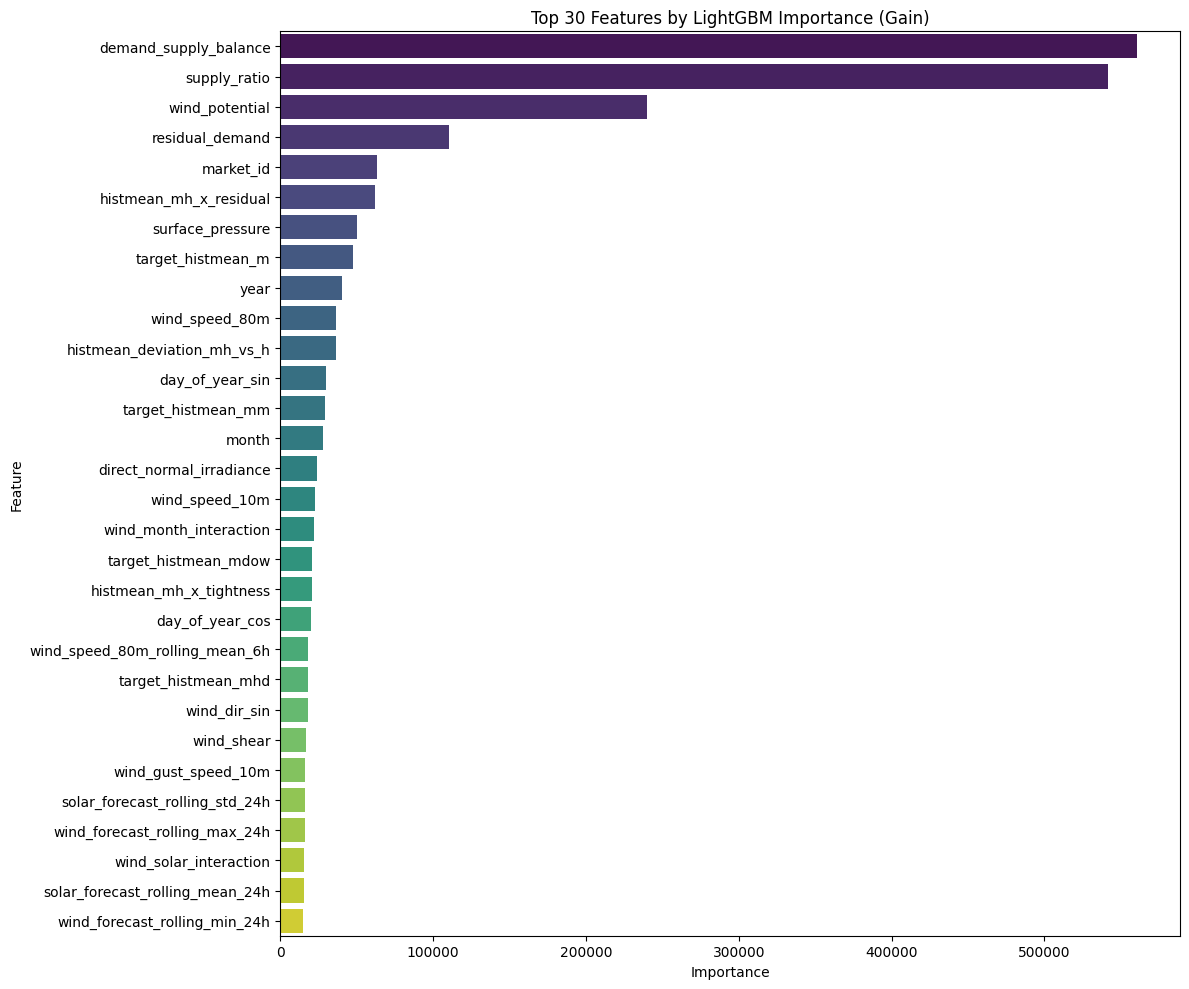


--- Bottom 20 Features (Consider Dropping) ---
                              Feature  Importance
           air_temperature_2m_diff_1h 1141.578005
                       is_weekend_end 1013.853937
                    is_business_hours  995.384294
               temp_solar_interaction  927.719098
                      wind_dir_change  835.810670
                             hour_sin  827.238501
                     wind_chill_proxy  790.826194
               wind_speed_80m_diff_1h  746.960404
                  q3_temp_interaction  672.410196
                   summer_load_factor  641.416545
convective_available_potential_energy  527.654500
                             hour_cos  484.491935
                     wind_cutout_risk  427.919987
                    target_histmean_h  372.935699
                lifted_index_negative  154.615862
                            is_friday  133.226900
           solar_forecast_market_diff   82.892101
                            is_winter   72.320801
  

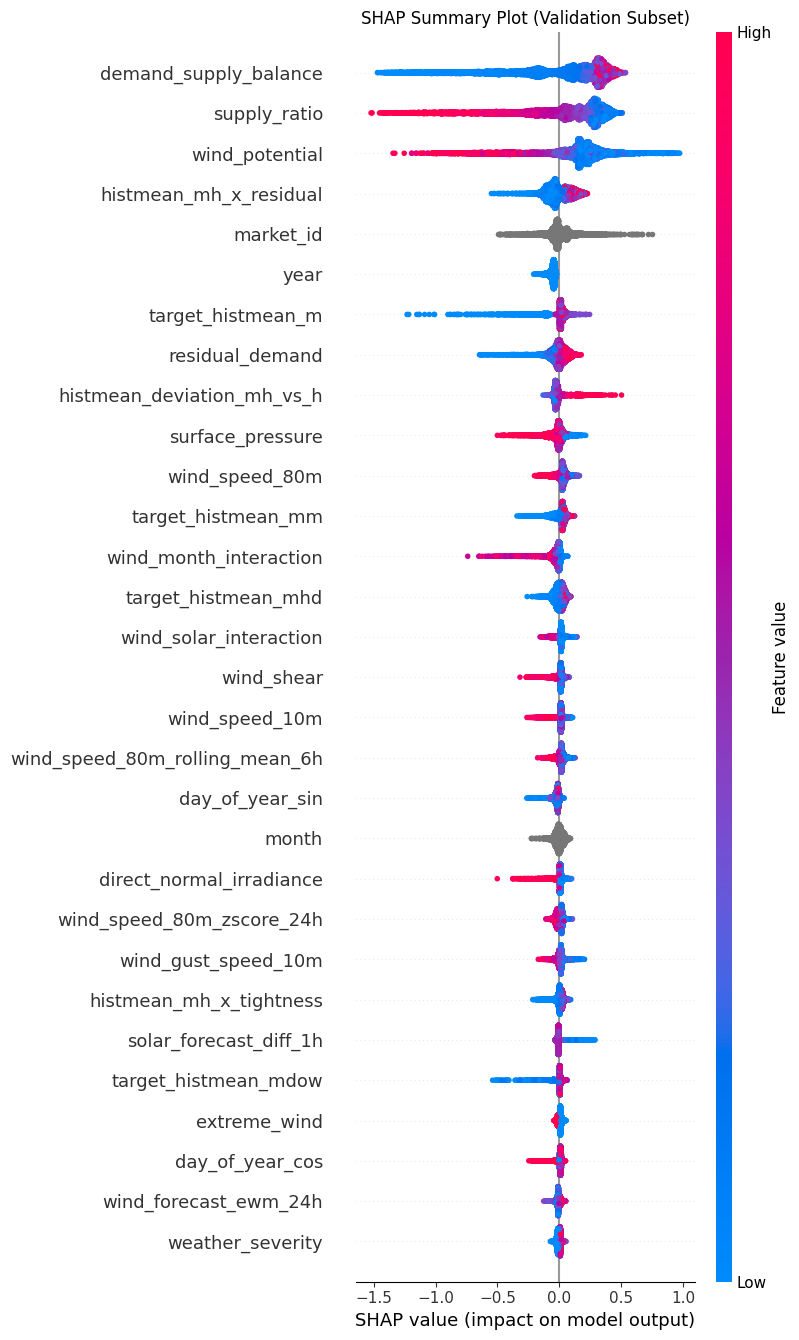


--- Top 20 Features Highly Correlated with Target (Absolute Pearson) ---
histmean_mh_x_residual           0.272987
residual_demand                  0.230962
histmean_mh_x_tightness          0.225167
vapour_pressure_deficit_2m       0.196549
target_histmean_mhd              0.191977
load_forecast                    0.181681
load_forecast_rolling_mean_6h    0.180652
cooling_degree_hours             0.180443
target_histmean_mh               0.171677
supply_ratio                     0.160017
wet_bulb_depression              0.153540
target_histmean_mm               0.152682
temp_load_interaction            0.152668
target_histmean_h                0.147298
tightness_x_hour                 0.144604
load_forecast_diff_12h           0.143672
load_forecast_ewm_24h            0.139000
wind_forecast_rolling_mean_6h    0.137291
demand_supply_balance            0.134720
wind_forecast                    0.126944
dtype: float64

Generating Multicollinearity Heatmap for Top Features...


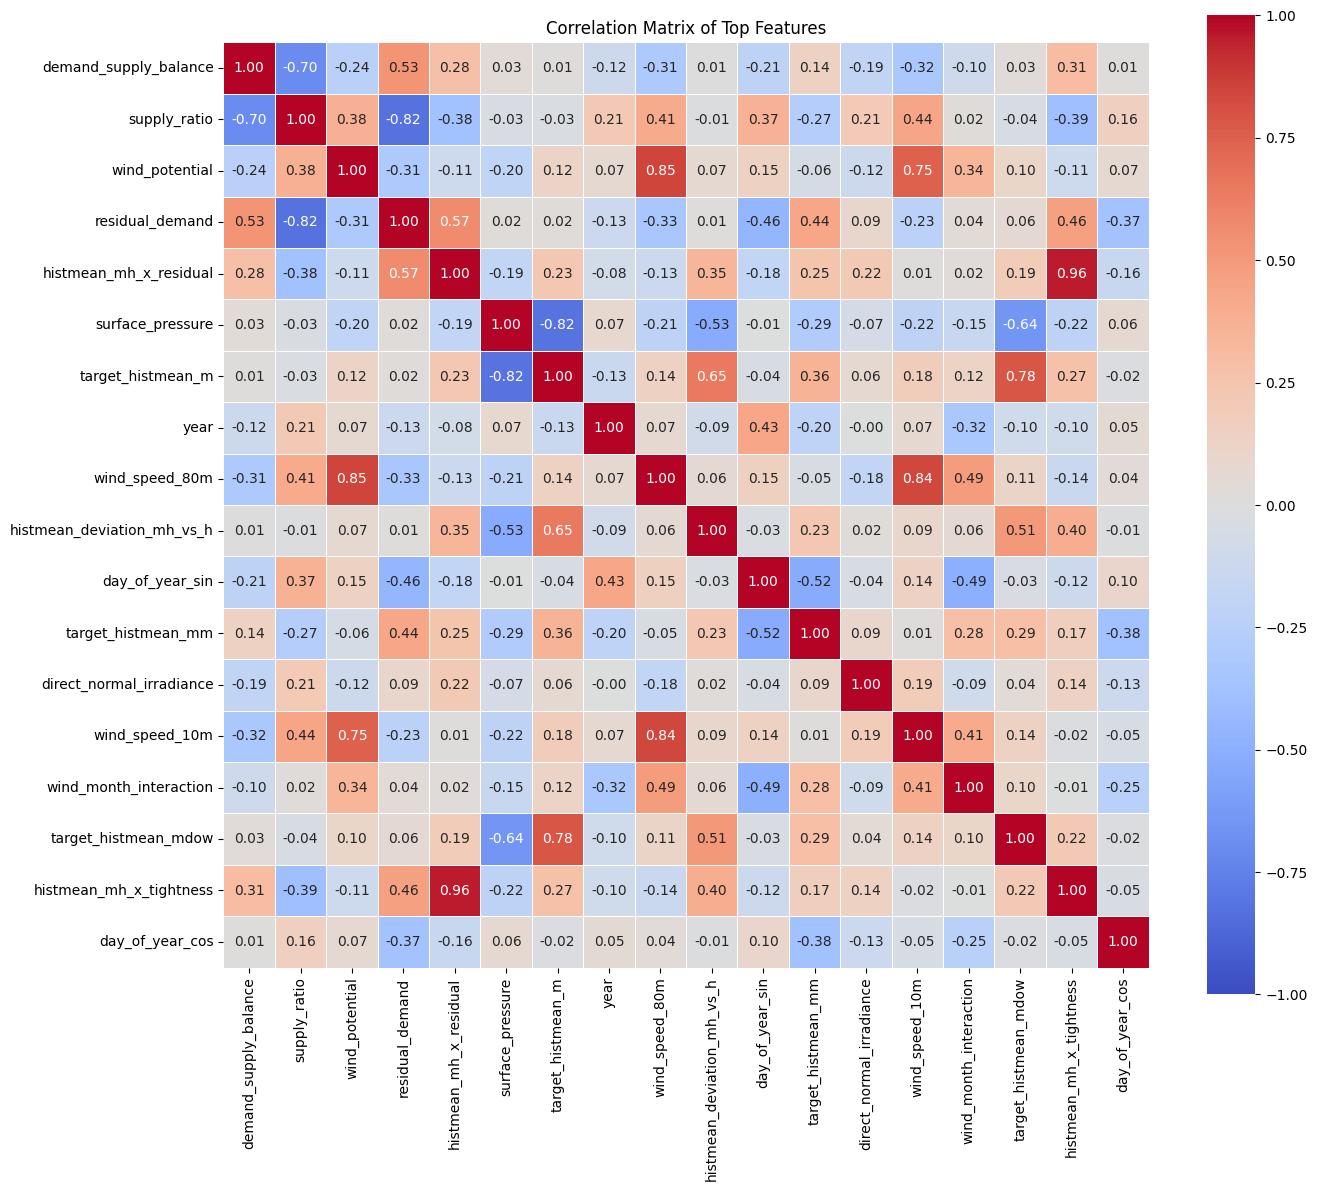

In [17]:
# ══════════════════════════════════════════════════════════════════════════════
# COMPREHENSIVE FEATURE ANALYSIS
# ══════════════════════════════════════════════════════════════════════════════

model = lgb_model  # The trained LightGBM Booster

print("Starting Comprehensive Feature Analysis...")

# ─── 1. LightGBM Built-in Feature Importance (Gain/Split) ────────────────────
try:
    importances = model.feature_importance(importance_type='gain')
    feature_names = model.feature_name()
    df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    df_imp = df_imp.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=df_imp.head(30), palette='viridis')
    plt.title("Top 30 Features by LightGBM Importance (Gain)")
    plt.tight_layout()
    plt.show()

    print("\n--- Bottom 20 Features (Consider Dropping) ---")
    print(df_imp.tail(20).to_string(index=False))
except Exception as e:
    print(f"Error in Feature Importance: {e}")

# ─── 2. SHAP Summary Plot ────────────────────────────────────────────────────
try:
    print("\nCalculating SHAP values (this may take a minute)...")
    sample_size = min(10000, len(X_val_physics))
    X_sample = X_val_physics[feat_cols].sample(n=sample_size, random_state=42)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    plt.figure(figsize=(12, 8))
    plt.title("SHAP Summary Plot (Validation Subset)")
    shap.summary_plot(shap_values, X_sample, max_display=30)
except Exception as e:
    print(f"Error in SHAP analysis: {e}")

# ─── 3. Feature-to-Target Correlation ────────────────────────────────────────
try:
    print("\n--- Top 20 Features Highly Correlated with Target (Absolute Pearson) ---")
    y_train_series = pd.Series(y_train_real, index=X_train.index)
    numeric_cols = X_train[feat_cols].select_dtypes(include=[np.number]).columns
    corr_with_target = X_train[numeric_cols].corrwith(y_train_series).abs()
    top_20_corr = corr_with_target.sort_values(ascending=False).head(20)
    print(top_20_corr)
except Exception as e:
    print(f"Error in Correlation: {e}")

# ─── 4. Multicollinearity Check ──────────────────────────────────────────────
try:
    print("\nGenerating Multicollinearity Heatmap for Top Features...")
    top_20_features = df_imp['Feature'].head(20).tolist()
    valid_features = [f for f in top_20_features
                      if f in X_train.columns and pd.api.types.is_numeric_dtype(X_train[f])]

    if len(valid_features) >= 5:
        corr_matrix = X_train[valid_features].corr()

        plt.figure(figsize=(14, 12))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                    vmin=-1, vmax=1, square=True, linewidths=.5)
        plt.title("Correlation Matrix of Top Features")
        plt.tight_layout()
        plt.show()
    else:
        print("  Not enough numeric features in top gain list for heatmap.")
except Exception as e:
    print(f"Error in Multicollinearity Check: {e}")

## Final Retrain & Test Predictions (LightGBM)

In [18]:
# ══════════════════════════════════════════════════════════════════════════════
# FINAL RETRAIN & TEST PREDICTIONS (LightGBM)
# ══════════════════════════════════════════════════════════════════════════════

# Retrain on ALL observed data (train+val) for final submission
print("Retraining on full observed data for submission...")

final_n_rounds = max(100, int(lgb_model.best_iteration * 1.1))
print(f'  Using {final_n_rounds} rounds (1.1x best_iteration={lgb_model.best_iteration})')

# Create weights for the FULL dataset
all_weights = np.ones(len(X_all))
all_target_mask = X_all['month'].isin([9, 10, 11, 12])
all_weights[all_target_mask] = 3.0

ds_all = lgb.Dataset(
    X_all[feat_cols], y_all,
    categorical_feature=cat_cols,
    weight=all_weights,  # <--- INJECTED WEIGHTS
    free_raw_data=False,
)

lgb_final = lgb.train(
    lgb_params, ds_all,
    num_boost_round=final_n_rounds,
)

# Predict on test set (with np.clip safety)
lgb_test_preds = np.sinh(np.clip(lgb_final.predict(X_test[feat_cols]), -20, 20))

print(f"✅ Test predictions generated: {len(lgb_test_preds):,} rows")

Retraining on full observed data for submission...
  Using 151 rounds (1.1x best_iteration=138)
✅ Test predictions generated: 13,098 rows


## Create Submission File

In [19]:
# ══════════════════════════════════════════════════════════════════════════════
# CREATE SUBMISSION FILE
# ══════════════════════════════════════════════════════════════════════════════

# Build prediction DataFrame keyed by id
pred_df = pd.DataFrame({
    "id": test_df["id"].values,
    "target": lgb_test_preds
})

# Merge onto sample_sub to guarantee identical id order
submission = sample_sub[["id"]].merge(pred_df, on="id", how="left")

# Sanity checks
assert len(submission) == len(sample_sub), f"Row mismatch: {len(submission)} vs {len(sample_sub)}"
assert submission["target"].isna().sum() == 0, f"Missing predictions for {submission['target'].isna().sum()} ids!"
assert (submission["id"] == sample_sub["id"]).all(), "ID order mismatch!"

# Save
submission_path = "../submissions/submission_v12_lgbm_winter_weighted.csv"
os.makedirs("../submissions", exist_ok=True)
submission.to_csv(submission_path, index=False)

print(f"✅ Submission saved: {submission_path}")
print(f"   Rows: {len(submission):,}")
print(f"   ID order matches sample_submission: ✓")
print(f"   Target stats:")
print(f"     Mean:   {submission['target'].mean():.4f}")
print(f"     Std:    {submission['target'].std():.4f}")
print(f"     Min:    {submission['target'].min():.4f}")
print(f"     Max:    {submission['target'].max():.4f}")
print(f"     Median: {submission['target'].median():.4f}")

✅ Submission saved: ../submissions/submission_v12_lgbm_winter_weighted.csv
   Rows: 13,098
   ID order matches sample_submission: ✓
   Target stats:
     Mean:   25.6593
     Std:    20.4555
     Min:    -7.6508
     Max:    190.8636
     Median: 22.8665
